# Turbulent stats demo
*Demonstrating the calculation of turbulent scales and scale-domain statistics for a solar wind dataset*

As well as raw variables such as electron density and magnetic field strength, and analytically-derived variables such as Alfven speed and ion gyroradius, the *Wind* database contains numerically-derived ("estimated") variables. The two parameters we are most interested are the *correlation scale* and *Taylor scale*. Both scales are calculated from the autocorrelation function, and both require some thought as to what technique to use to calculate them.

## To-do
Right now I am unifying my codes, especially across this project and the sf_gap_analysis project. While it might seem they are doing different things (this has no SFs or gaps, the other has just those), we will need both for the next steps, which will involve correlation scales for gapped Wind data. Therefore, in the interests of simplicity, consistency, and comprehensiveness, we want to unify (the `src` code) of the two codebases.

## Notes
- The interval used to demonstrate the pipeline is not ideal in that its ACF lacks the desired parabolic shape near the origin and overall exponential shape. However, it is still a useful demonstration given that not all ACFs will have this nice shape.
- Scales are returned in units of seconds
- For demonstration purposes, `plot=True` arguments in functions assume a solar wind speed of 400km/s. The specific speeds measured for each interval are used in the actual analysis. 
- We expect slight variation from Kevin's numbers due to using a cadence of 11Hz instead of 10Hz.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import importlib
from sunpy.timeseries import TimeSeries

# import os
# while ".toplevel" not in os.listdir():
#     os.chdir("..")

import src.utils as utils
import src.params as params

import warnings
from sunpy.util import SunpyUserWarning
import src.ts_dashboard_utils as ts


# Suppress SunpyUserWarning warnings (referring to missing metadata for unwanted columns)
warnings.simplefilter("ignore", SunpyUserWarning)

sys_arg_dict = {
    # arg1
    "mag_path": params.mag_path,
    "proton_path": params.proton_path,
    "electron_path": params.electron_path,
    # arg2
    "mag_vars": [params.timestamp, params.Bwind, params.Bwind_vec],
    "proton_vars": [params.timestamp, params.np, params.Tp],
    "electron_vars": [params.timestamp, params.ne, params.Te],
    # arg3
    "mag_thresh": params.mag_thresh,
    "proton_thresh": params.proton_thresh,
    "electron_thresh": params.electron_thresh,
    # arg4
    "dt_hr": params.dt_hr,
    "int_size": params.int_size,
    # arg5
    "dt_lr": params.dt_lr,
}

# Set fontsize of plots (check matches utils.py)
plt.rcParams.update({"font.size": 9})
plt.rc("text", usetex=True)

In [2]:
# Use this block to reload the module if changes are made to the source code, without restarting the kernel
importlib.reload(utils)

<module 'src.utils' from 'c:\\Users\\spann\\Documents\\Research\\Code repos\\reynolds_scales_project\\src\\utils.py'>

In a bash terminal, run `bash 0_download_files.sh`, followed by `bash 1_get_raw_vars.sh`. (For some reason `%%bash` command in a Jupyter cell isn't working)

## Preparing data

In [3]:
file = "data/raw/wind/mfi/mfi_h2/2016/wi_h2_mfi_20160102_v05.cdf"

# Rename and keep only the first three columns
mag_vars = ["BF1", "BGSE_0", "BGSE_1", "BGSE_2"]

In [4]:
# df = utils.pipeline(
#     file,
#     varlist=sys_arg_dict["mag_vars"],
#     thresholds=sys_arg_dict["mag_thresh"],
#     cadence=sys_arg_dict["dt_hr"],
# )
# # print("Reading {0}: {1:.2f}% missing".format(file, df.iloc[:,0].isna().sum()/len(df)*100))

# # Ensuring observations are in chronological order
# df_wind_hr = df.sort_index()

# df_wind_hr.head()

In [5]:
data_raw = TimeSeries(file, concatenate=True, allow_errors=False)

df_raw = data_raw.to_dataframe()

df_raw = df_raw.loc[:, mag_vars]

df_raw = df_raw.rename(
    columns={
        mag_vars[0]: "Bwind",
        mag_vars[1]: "Bx",
        mag_vars[2]: "By",
        mag_vars[3]: "Bz",
    }
)

df_raw.shape

(921437, 4)

In [6]:
df_raw.head()

,Bwind,Bx,By,Bz
2016-01-02 00:00:00.038,5.175841,3.600062,-3.369953,1.572357
2016-01-02 00:00:00.130,5.165134,3.574639,-3.366601,1.602051
2016-01-02 00:00:00.222,5.127500,3.557657,-3.337525,1.579638
2016-01-02 00:00:00.314,5.187399,3.607577,-3.371623,1.589545
2016-01-02 00:00:00.406,5.155786,3.583828,-3.343059,1.600705


In [7]:
cadence = df_raw.index.to_series().diff().value_counts().head()
cadence

0 days 00:00:00.092000    918470
0 days 00:00:00.184000        92
0 days 00:00:00.018000        38
0 days 00:00:00.034000        38
0 days 00:00:00.091000        38
Name: count, dtype: int64

### Selecting an interval and resampling

Extracting a single 12-hour interval to demonstrate the pipeline, and resampling to high-cadence and low-cadence version for different purposes.

In [8]:
df_hr = df_raw.resample(params.dt_hr).mean()
df_hr["Bx"].to_pickle("data/processed/" + "B_" + params.dt_hr + ".pkl")

In [9]:
timestamp = "2016-01-02 12:00:00"  # Refers to data betweeen 00:00 and 12:00

int_hr = df_hr[
    pd.to_datetime(timestamp) : pd.to_datetime(timestamp)
    + pd.to_timedelta(params.int_size)
]


int_hr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 469565 entries, 2016-01-02 12:00:00.072000 to 2016-01-02 23:59:59.960000
Freq: 92ms
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Bwind   459891 non-null  float32
 1   Bx      459891 non-null  float32
 2   By      459891 non-null  float32
 3   Bz      459891 non-null  float32
dtypes: float32(4)
memory usage: 10.7 MB


In [10]:
int_hr.isna().sum()

Bwind    9674
Bx       9674
By       9674
Bz       9674
dtype: int64

In [11]:
int_lr = int_hr.resample(params.dt_lr).mean()
int_lr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8640 entries, 2016-01-02 12:00:00 to 2016-01-02 23:59:55
Freq: 5s
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Bwind   8474 non-null   float32
 1   Bx      8474 non-null   float32
 2   By      8474 non-null   float32
 3   Bz      8474 non-null   float32
dtypes: float32(4)
memory usage: 202.5 KB


C:\Users\spann\AppData\Local\Temp\ipykernel_9516\4053495500.py:1: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  int_lr = int_hr.resample(params.dt_lr).mean()


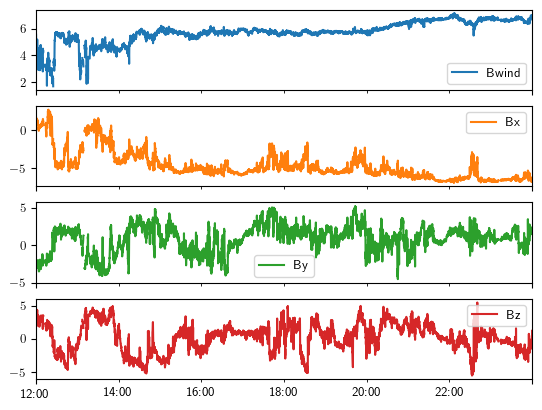

In [12]:
int_lr.plot(subplots=True)
plt.show()

### Handling missing data

In [13]:
int_hr.isna().sum()

Bwind    9674
Bx       9674
By       9674
Bz       9674
dtype: int64

In [14]:
int_lr.isna().sum()

Bwind    166
Bx       166
By       166
Bz       166
dtype: int64

In [15]:
missing = int_hr.iloc[:, 0].isna().sum() / len(int_hr)
print(missing)

if missing > 0.4:
    # Replacing values in lists with na
    print("Large missing %")
else:
    int_hr = int_hr.interpolate().ffill().bfill()
    int_lr = int_lr.interpolate().ffill().bfill()

0.020602046575021564


In [16]:
int_hr.isna().sum()

Bwind    0
Bx       0
By       0
Bz       0
dtype: int64

In [17]:
int_lr.isna().sum()

Bwind    0
Bx       0
By       0
Bz       0
dtype: int64

### Standardising

In [116]:
int_lr_norm = utils.normalize(int_lr)

## Calculating stats

### PSD

In order to fully implement Chuychai's method, we need the spectral index (slope) of the power law in the dissipation range. Here we compute a smoothed 3D periodogram for a single high-res interval, then perform a least squares fit of a power law to the inertial and kinetic ranges to determine their slopes and the spectral break.

**Maths for calculating breakpoint:**

Each power-law fit is given by the following equation:

$$y =x^me^c$$

This is because if we take the log of both sides, we get the formula for a straight line on a log-log plot:

$$\log(y) = m\log(x)+c$$

We want to find the x-value for which the two power-laws are equal. We can do this by subtracting one from the other and finding the value of $\log(x)$ where this subtraction = 0, i.e., the root of the equation.

$$m_1\log(x)+c_1-m_2\log(x)-c_2=0$$

Finally, we take the exponential of this root to get the x-value of the spectral break

$$x = e^{\log(x)}$$

The following requires specification of the inertial and kinetic ranges. I have used the values used previously in the literature for Wind spectral analysis. Sometimes we cannot get a good intersection between the two for a spectral break.

In [18]:
# Reading in dataframe to get values for qi, di, etc.
df_wind = pd.read_csv("wind_dataset.csv", index_col="Timestamp")
df_wind.index = pd.to_datetime(df_wind.index)

(np.float64(-1.7404230978029134),
 np.float64(-3.026077167095732),
 np.float64(0.20382610777459942))

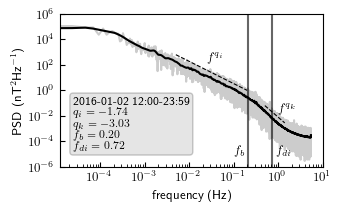

In [ ]:
# Takes a while, mostly because of smoothing
qi, qk, spectral_break, fig, ax, f_periodogram, p_smooth = utils.compute_spectral_stats(
    [int_hr.Bx, int_hr.By, int_hr.Bz],
    # dt=float(params.dt_hr[:-1]),
    f_min_inertial=params.f_min_inertial,

    f_max_inertial=params.f_max_inertial,
    f_min_kinetic=params.f_min_kinetic,

    f_max_kinetic=params.f_max_kinetic,
    timestamp=timestamp,

    di=df_wind.loc[timestamp, "dp"],
    velocity=df_wind.loc[timestamp, "V0"],
    plot=True,
)



qi, qk, spectral_break

In [20]:
# fig.savefig("plots/final/spectrum_annotated.pdf")

- $\alpha_{i}=-1.66$
- $\alpha_{k}=-2.4$
- $f_d=0.26$ Hz (dissipation scale)
- $\tau_d=1/f_d=1/0.26=3.8$

Chuychai et al. recommend that the resolution of the data be at least as good as $\Delta t <0.4\tau_d$. We later find the mean value of $\tau_d$ to be $1/0.25=4$. Using this value, we see our resolution is sufficient:

- $1/11 = 0.091$
- $0.4\times4=1.6$
- $0.091 < 1.6$

<u>We need to justify the frequency bounds we have specified for fitting the power law slopes.</u>
See e.g. *The kinetic range is usually above the spacecraft frame frequency corresponding to the proton inertial length, $f_{pi}=v_{SW}/(2\pi\lambda_{pi}$)* (from Pitna et al. (2021), quantities plotted as vertical lines above).

### ACF

This is what we use to calculate the correlation scale and Taylor scale. Note that Chuychai et al. did not calculate the ACF directly from the data; they calculated it from the second-order structure function. Here, we will calculate it directly from the data.

The following function is based off Kevin's `compute_corr.compute_correlation_time_scale.compute_autocorrelation_function()`. It automatically detects whether being fed 1D (scalar) or 3D time series, for which the calculation is as follows:

$$R(\tau)=\frac{1}{3}\times(R_{xx}(\tau)+R_{yy}(\tau)+R_{zz}(\tau))$$

The following low-cadence, high $r$ ACF will be used for calculating the outer scale.

In [53]:
importlib.reload(utils)

<module 'src.utils' from 'c:\\Users\\spann\\Documents\\Research\\Code repos\\reynolds_scales_project\\src\\utils.py'>

In [57]:
len(int_lr_norm)

8640

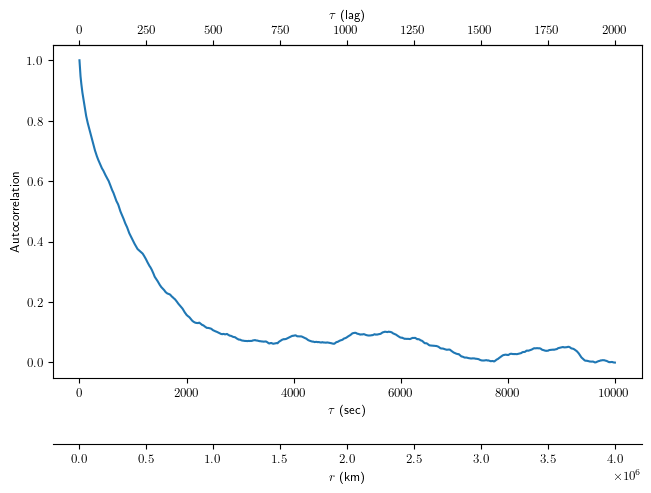

In [155]:
time_lags_lr, r_vec_lr = utils.compute_nd_acf(
    [int_lr_norm.Bx, int_lr_norm.By, int_lr_norm.Bz],
    nlags=params.nlags_lr,
    plot=True,
)

The following high-cadence, low $r$ ACF will be used for calculating the Taylor scale.

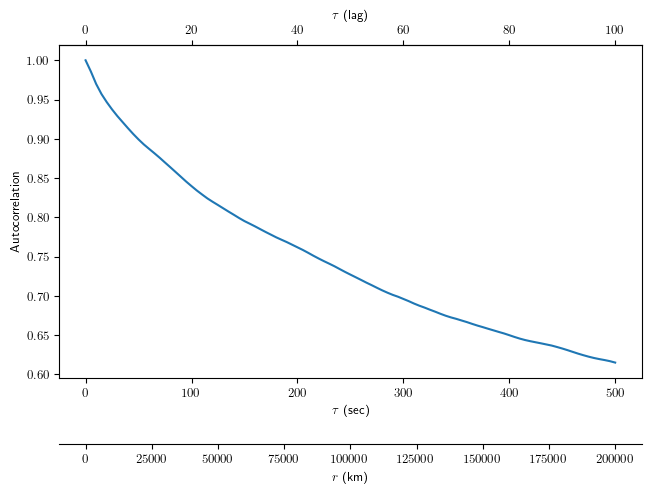

In [119]:
time_lags_hr, r_vec_hr = utils.compute_nd_acf(
    [int_lr_norm.Bx, int_lr_norm.By, int_lr_norm.Bz],
    nlags=params.nlags_hr,
    plot=True,
)

#### Correlation scale

An approximation of the outer scale of turbulence, this is the scale beyond which turbulent fluctuations are practically no longer correlated.

Methods for calculating:
- 1/e trick
- Exponential fit
- Integration (hence the other name *integral scale*)

Smith et al. (2001) used the 1/e trick method (which they call $e$-folding) and the integration method. In Appendix B of their paper, they show how the estimates by either method increase depending on the lag up to which you calculate the ACF.

Firstly, using Kevin's function (just with plotting functionality added) for computing outer scale using $1/e$ trick:

**If we set $f(\tau)=\exp(-\tau/\tau_c)=e^{-1}$, then $\tau_c=\tau$.**

Kevin referred to the value calculated from this method in his analysis as `estimate` and `Correlation_timescale_est`.

np.float64(1129.727)

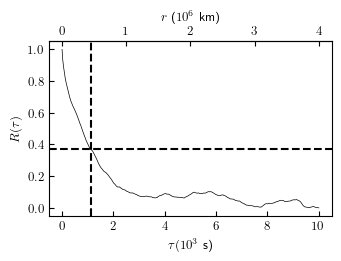

In [156]:
tce, fig, ax = utils.compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, plot=True)
tce

What values should we expect? The lit review spreadsheet shows values in the range of $\lambda_C=$ 320,000 - 1,200,000km.

Secondly, adapting Kevin's function for computing outer scale using exponential fit, from `compute_correlation_time_scale()`. A function of the following form is fit to the ACF $R(\tau)$.

$$f(\tau)=\exp(-\tau/\tau_c)$$


Kevin referred to the value calculated from this method as `lambda_c` and `Correlation_timescale`.

<u>How to choose how much of the ACF to fit to?</u> Kevin used 1000 seconds, which was decided "through some trial and error and inspection of plotted results". While we should keep in mind that the correlation length will tend to increase with the maximum lag we fit to, I think we should fit to much more than 1000 seconds, as in the literature we see typical fits to 1-3,000,000km, corresponding to 2500-7500 seconds or 500-1500 lags. **We are now fitting to 2 times the correlation timescale, as estimated by the 1/e method.**

**Fit to 2 * 1/e estimate**

In [157]:
tcf, fig, ax = utils.compute_outer_scale_exp_fit(
    time_lags=time_lags_lr,
    acf=r_vec_lr,
    seconds_to_fit=np.round(2 * tce),
    fig=fig,
    ax=ax,
    plot=True,
)
tcf

np.float64(1085.4295099148665)

Finally, creating a function for computing outer scale as integral of the ACF. This formula comes from the re-arrangement of the simple exponential that a time series follows if it approximates a Markov process (Batchelor, 1970). 

$$\tau_C=\int_0^\infty R(\tau)d\tau$$

In [158]:
tci, fig, ax = utils.compute_outer_scale_integral(
    time_lags_lr, r_vec_lr, fig=fig, ax=ax, plot=True
)
tci

np.float64(1380.5474744275143)

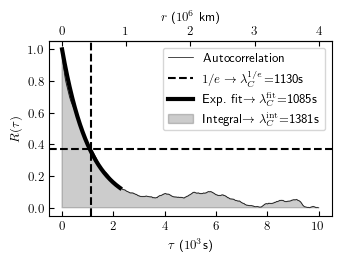

In [159]:
fig

In [27]:
fig.savefig("plots/final/corr_scale_methods.pdf")

Isaacs et al. (2015) looked at the effect of **interval size** on the estimate of the correlation length, using data from ACE and comparing against the "true", multi-spacecraft value. The plots below line up quite well with the values calculated from our 6-hour intervals. In the accompanying discussion on pg10 of the paper, they state "averaging intervals of 10-20 hours appear to have a special significance with regard to computation of correlation scales."


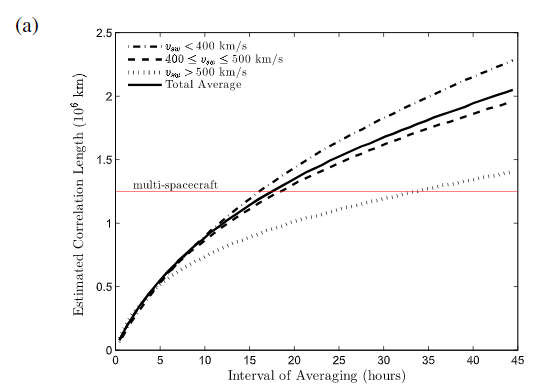

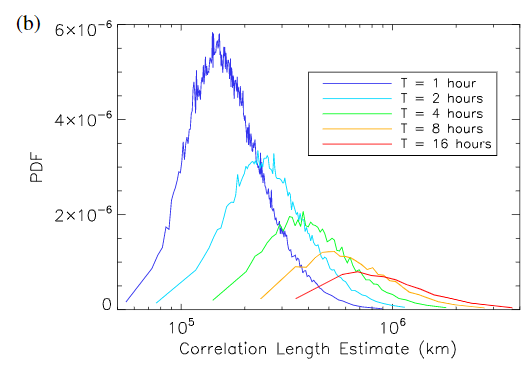

#### Taylor scale

Taylor microscale (time domain) = $\tau_{TS}$ = radius of curvature of ACF at the origin. 

Can calculate using second derivative of the ACF at the origin, but this is not commonly done as it is very sensitive to behaviour at the origin. Here we use the parabolic fit method. This code is adapted from Kevin's `compute_taylor_time_scale()`.

Previously this function took the number of seconds to fit the parabola over as the input, and then converted this to the number of lags. (This was chosen to be 2 seconds = 20 lags.) In line with Chuychai's method, this function now takes the number of lags `tau_fit` as input directly.

c:\Users\spann\Documents\Research\Code repos\reynolds_scales_project\src\utils.py:770: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-y" (-> color='y'). The keyword argument will take precedence.
  ax[0].plot(


np.float64(15.771723433957924)

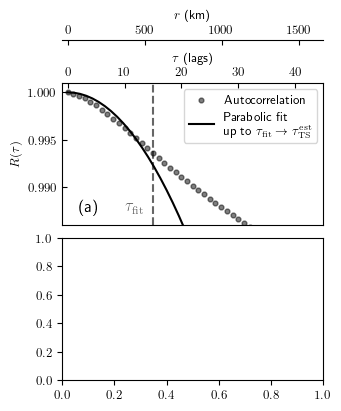

In [28]:
lambda_t, fig, ax = utils.compute_taylor_scale(
    time_lags_hr, r_vec_hr, tau_fit=15, plot=True, show_intercept=False
)
lambda_t
# Set show_intercept = True if you want piece of mind that the value returned is actually the x-intercept

##### Chuychai correction
We can't just use the above function for some very small lag close to the origin, because as noted by Chuychai et al., "it is not practical to compute this limit because the data has a finite time resolution and there may be limited data available at the shortest time lags". Therefore, we can calculate the Taylor scale from a parabolic fit for a *range* of values of $\tau_{fit}$, up to $\tau_{max}$. Plot these values as a function of $\tau_{fit}$, then draw a straight line through the points back to $\tau_{fit}=0$. 

See lit review spreadsheet for ranges of $\tau_{fit}$ in other studies.

Chuychai's notation:
- $\tau_{fit}$: parabola is fitted from $\tau=0$ to $\tau=\tau_{fit}$
- $\tau_{TS}^{est}(\tau_{fit})$ = estimate of $\tau_{TS}$ for a given value of $\tau_{fit}$
- $\tau_{TS}^{extra}$: estimate obtained by the extrapolation method
- $\tau_{TS}$: final estimate after applying correction factor
- $q$ = dissipation scale index
- $\tau_{d}$ = Kolmogorov scale (time domain) - point where the inertial range terminates and the spectrum steepens

<u>How do we choose the upper value, $\tau_{max}$?</u> This is investigated in Fig. 5 of Chuychai. Weygand et al. (2007) show an example of reaching a stable estimate as $\tau_{max}$ increases, but Chuychai shows that this is dependent on the spectral index. In particular, they note that we are more likely to reach a stable estimate of $\lambda_{TS}$ after extrapolation when we have a steep spectral index $q$ in the dissipation range. A smaller $q$ means we do not obtain a stable estimate.

**Here we have decided to set $\tau_{min}$ = 10 lags $\approx 1s $ and $\tau_{max}$= 50 lags $\approx 5s$.** This is roughly in line with what Chuychai & Matthaeus did for ACE data, while reducing $\tau_{max}$ due to understanding that we will not get convergence with increasing $\tau_{max}$ due to the relatively shallow values of $q$. This also matches their recommendation that a good estimate is obtained by an extrapolation of the curves evaluated near $\tau_{max}=\tau_d=4s$.

Chuychai et al. then developed an additional correction factor "which can be used when estimates of the [slope of the] high-frequency spectrum of the signal are available in some way, whether it be observations, theory, or an informed guess". The equation for this final estimate is given in Eq. 10 of the paper, and is coded into the following function.

We can compare the following to Fig. 4 in Chuychai, and less directly to Figs. 5 and 7 in Weygand et al. (2007)

In [29]:
# Not applying Chuychai correction factor
ts_est_extra, ts_est_extra_std = utils.compute_taylor_chuychai(
    time_lags_hr, r_vec_hr, tau_min=params.tau_min, tau_max=params.tau_max
)
ts_est_extra

np.float64(10.620638938079324)

In [30]:
# Applying Chuychai correction factor
ts_est, ts_est_std, fig, ax = utils.compute_taylor_chuychai(
    time_lags_hr,
    r_vec_hr,
    tau_min=params.tau_min,
    tau_max=params.tau_max,
    q=df_wind.loc[timestamp, "qk"],
    fig=fig,
    ax=ax,
)
print(ts_est, ts_est_std)

8.894755492195829 0.04590859183297489


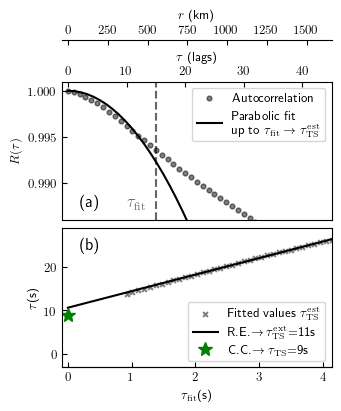

In [31]:
fig

In [32]:
fig.savefig("plots/final/taylor_scale_methods.pdf")

In [33]:
# Meta-analysis: dependence on t_max. Takes ~ 4min to run

# tau_max_lower = 20
# tau_max_upper = 1000

# tau_fit_max = np.arange(tau_max_lower, tau_max_upper +1)
# tau_ts_meta = np.array([])

# for i in tau_fit_max:
#     ts_est_final = compute_taylor_chuychai(time_lags_hr, r_vec_hr, tau_min=10, tau_max=i, q = -2.14, show = False)
#     tau_ts_meta = np.append(tau_ts_meta, ts_est_final)

# plt.plot(tau_fit_max, tau_ts_meta)
# plt.xlabel("$\\tau_{max}$")
# plt.ylabel("$\\tau_{final}$")
# plt.show()

These settings can be investigated by looking at the output plots of the `calculate_numerical_vars.py` script. These show the ACFs and fits for the min, median and max correlation scale (exp method) and Taylor scale.

### SF

In [34]:
importlib.reload(params)

<module 'src.params' from 'c:\\Users\\spann\\Documents\\Research\\Code repos\\reynolds_scales_project\\src\\params.py'>

In [35]:
import src.sf_funcs as sf
import src.data_import_funcs as dif

powers = [2, 4]
pwrl_range = params.pwrl_range
lags = np.arange(1, params.max_lag_prop * params.int_length)

In [124]:
input = int_lr_norm[["Bx", "By", "Bz"]]

In [125]:
good_output, slope = sf.compute_sf(
    data=input,
    lags=lags,
    powers=powers,
    retain_increments=False,
    alt_estimators=False,
    pwrl_range=pwrl_range,
)
good_output.head()

,lag,n,missing_percent,sf_2,sf_2_se,sf_4,sf_4_se
1.0,1.0,8639,0.0,0.083423,0.002886,0.078901,0.013440
2.0,2.0,8638,0.0,0.176620,0.005967,0.338705,0.049943
3.0,3.0,8637,0.0,0.251065,0.007937,0.607068,0.067846
4.0,4.0,8636,0.0,0.311181,0.009228,0.832167,0.081708
5.0,5.0,8635,0.0,0.364588,0.010212,1.033372,0.091656


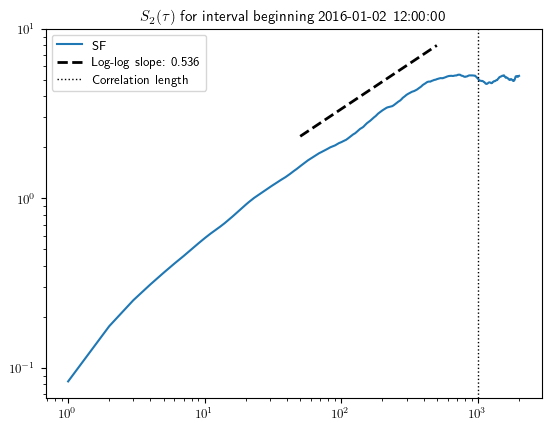

In [126]:
tc_n = 10

plt.plot(
    good_output["lag"],
    good_output["sf_2"],
    label="SF",
)
dif.pltpwrl(
    pwrl_range[0],
    good_output.loc[pwrl_range[0], "sf_2"] * 1.5,
    pwrl_range[0],
    pwrl_range[1],
    slope,
    lw=2,
    ls="--",
    color="black",
    label=f"Log-log slope: {slope:.3f}",
)

# Add vertical line at tc

tc_lag = params.int_length / tc_n

plt.axvline(tc_lag, color="black", linestyle="dotted", lw=1, label="Correlation length")

plt.semilogx()

plt.semilogy()

plt.title(f"$S_2(\\tau)$ for interval beginning {timestamp}")
plt.legend()

# output_file_path = (

#     raw_file_list[file_index]

#     .replace("data/raw", "plots/preprocessing")

#     .replace(".cdf", "_sf_example.pdf")

# )

# plt.savefig(output_file_path, bbox_inches="tight")

# plt.close()

### SDK

Text(0.5, 1.0, 'Scale-dependent Kurtosis')

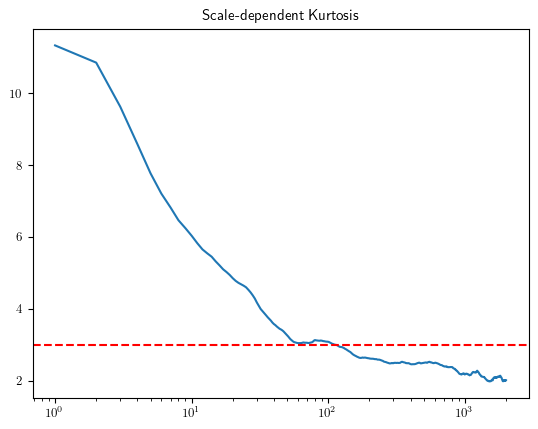

In [127]:
plt.plot(good_output.index, good_output["sf_4"] / good_output["sf_2"] ** 2)
plt.semilogx()
# Add horizontal line at 3
plt.axhline(y=3, color="r", linestyle="--")
plt.title("Scale-dependent Kurtosis")

### Equivalent spectrum

Following Thepthong et al. (2024)

-1.3419156289794167


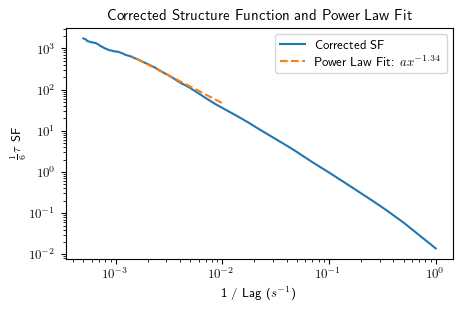

In [128]:
# Fit a power law to the corrected SF
from scipy.optimize import curve_fit


def power_law(x, a, b):
    return a * x**b


sf_lags = good_output.lag.values
sf_corrected = good_output.sf_2.values
sf_corrected_es = sf_corrected * sf_lags / 6

popt, pcov = curve_fit(power_law, 1 / sf_lags[100:700], sf_corrected_es[100:700])

print(popt[1])

# Plotting the corrected structure function and the power law fit
plt.figure(figsize=(5, 3))
plt.loglog(1 / sf_lags, sf_corrected_es, label="Corrected SF")
plt.loglog(
    1 / sf_lags[100:700],
    power_law(1 / sf_lags[100:700], *popt),
    label=f"Power Law Fit: $a x^{{{popt[1]:.2f}}}$",
    linestyle="--",
)
plt.xlabel("1 / Lag ($s^{-1}$)")
plt.ylabel("$\\frac{1}{6} \\tau$ SF")
plt.title("Corrected Structure Function and Power Law Fit")
plt.legend()
# plt.grid(True, which="both", ls="--")
plt.show()

## Simulating gaps

Nominal total removal: 66.2%
Nominal ratio: 78.6%
Total proportion removed: 66.2%


c:\Users\spann\Documents\Research\Code repos\reynolds_scales_project\venv\lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\spann\Documents\Research\Code repos\reynolds_scales_project\src\ts_dashboard_utils.py:103: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prop_removed[
c:\Users\spann\Documents\Research\Code repos\reynolds_scales_project\venv\lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a sca

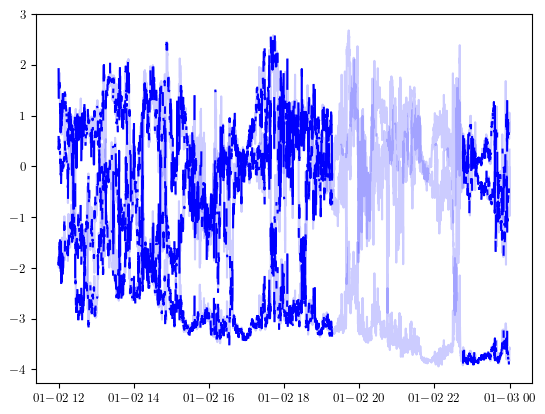

In [129]:
minimum_missing_chunks = 0.7
np.random.seed(123)  # For reproducibility

total_removal = np.random.uniform(0, 0.95)
ratio_removal = np.random.uniform(minimum_missing_chunks, 1)
print("Nominal total removal: {0:.1f}%".format(total_removal * 100))
print("Nominal ratio: {0:.1f}%".format(ratio_removal * 100))
prop_remove_chunks = total_removal * ratio_removal

bad_input_chunks, bad_input_ind_chunks, prop_removed_chunks = ts.remove_data(
    input, prop_remove_chunks, chunks=np.random.randint(1, 10)
)
# Now calculate amount to remove uniformly, given that
# amount removed in chunks will invariably differ from specified amount
prop_remove_unif = total_removal - prop_removed_chunks

# Add the uniform gaps on top of chunks gaps
bad_input, bad_input_ind, prop_removed = ts.remove_data(
    bad_input_chunks, prop_remove_unif
)

# Check that the total proportion removed is as expected
print("Total proportion removed: {0:.1f}%".format(prop_removed * 100))

plt.plot(input, alpha=0.2, color="blue")
plt.plot(bad_input, color="blue")

## Analysing effect of gaps

Power spectrum does not work, as expected, due to use of FFT algorithm

In [130]:
# Takes a while, mostly because of smoothing
qi, qk, spectral_break, fig, ax, f_periodogram, p_smooth = utils.compute_spectral_stats(
    [bad_input.Bx],
    # dt=float(params.dt_hr[:-1]),
    f_min_inertial=params.f_min_inertial,
    f_max_inertial=params.f_max_inertial,
    f_min_kinetic=params.f_min_kinetic,
    f_max_kinetic=params.f_max_kinetic,
    timestamp=timestamp,
    di=df_wind.loc[timestamp, "dp"],
    velocity=df_wind.loc[timestamp, "V0"],
    plot=True,
)


qi, qk, spectral_break

TypeError: expected non-empty vector for x

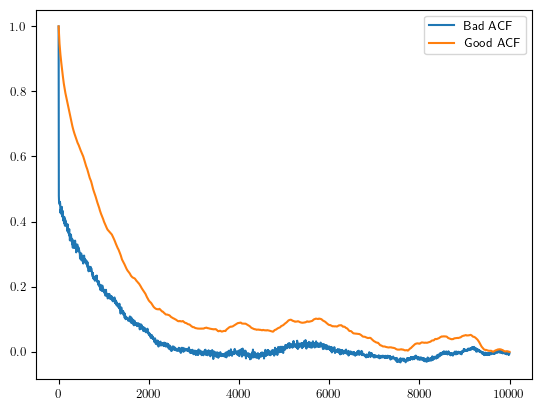

In [131]:
time_lags_lr_bad, r_vec_lr_bad = utils.compute_nd_acf(
    [bad_input.Bx, bad_input.By, bad_input.Bz],
    nlags=params.nlags_lr,
    plot=False,
)

# Plot bad ACF overlaying good ACF
plt.plot(time_lags_lr_bad, r_vec_lr_bad, label="Bad ACF")
plt.axvline(ts_est, color="black", linestyle="--", label="Taylor Scale")
plt.plot(time_lags_lr, r_vec_lr, label="Good ACF")
plt.legend()

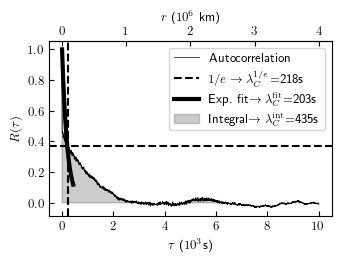

In [160]:
tce, fig, ax = utils.compute_outer_scale_exp_trick(
    time_lags_lr_bad, r_vec_lr_bad, plot=True
)
tcf, fig, ax = utils.compute_outer_scale_exp_fit(
    time_lags=time_lags_lr_bad,
    acf=r_vec_lr_bad,
    seconds_to_fit=np.round(2 * tce),
    fig=fig,
    ax=ax,
    plot=True,
)
tci, fig, ax = utils.compute_outer_scale_integral(
    time_lags_lr_bad, r_vec_lr_bad, fig=fig, ax=ax, plot=True
)

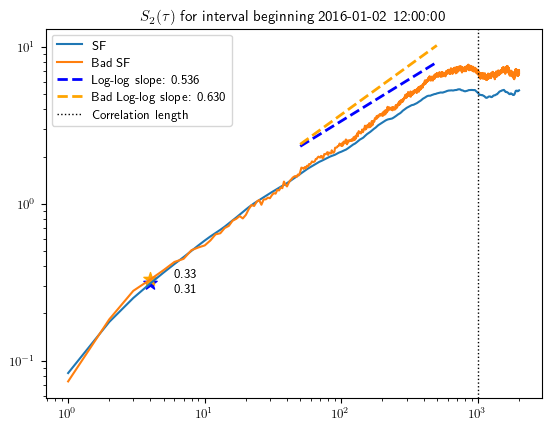

In [149]:
bad_output, bad_slope = sf.compute_sf(
    data=bad_input,
    lags=lags,
    powers=powers,
    retain_increments=False,
    alt_estimators=False,
    pwrl_range=pwrl_range,
)

tc_n = 10

plt.plot(
    good_output["lag"],
    good_output["sf_2"],
    label="SF",
)
plt.plot(
    bad_output["lag"],
    bad_output["sf_2"],
    label="Bad SF",
)
dif.pltpwrl(
    pwrl_range[0],
    good_output.loc[pwrl_range[0], "sf_2"] * 1.5,
    pwrl_range[0],
    pwrl_range[1],
    slope,
    lw=2,
    ls="--",
    color="blue",
    label=f"Log-log slope: {slope:.3f}",
)
dif.pltpwrl(
    pwrl_range[0],
    bad_output.loc[pwrl_range[0], "sf_2"] * 1.5,
    pwrl_range[0],
    pwrl_range[1],
    bad_slope,
    lw=2,
    ls="--",
    color="orange",
    label=f"Bad Log-log slope: {bad_slope:.3f}",
)

# Also extract the 20s level (4xdt) from the SF
level = good_output.loc[4, "sf_2"]
bad_level = bad_output.loc[4, "sf_2"]
# Add these values as stars at their corresponding location, with the value next to them
plt.scatter(4, level, color="blue", marker="*", s=100)
plt.text(6, level, f"{level:.2f}", verticalalignment="top")
plt.scatter(4, bad_level, color="orange", marker="*", s=100)
plt.text(6, bad_level, f"{bad_level:.2f}", verticalalignment="bottom")

# Add vertical line at tc

tc_lag = params.int_length / tc_n

plt.axvline(tc_lag, color="black", linestyle="dotted", lw=1, label="Correlation length")

plt.semilogx()

plt.semilogy()

plt.title(f"$S_2(\\tau)$ for interval beginning {timestamp}")
plt.legend()

Text(0.5, 1.0, 'Scale-dependent Kurtosis')

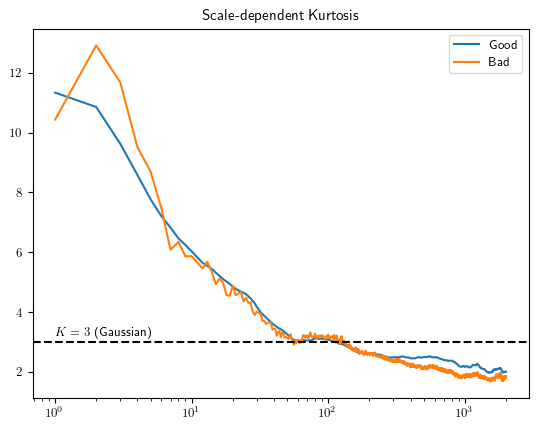

In [140]:
plt.plot(
    good_output.index, good_output["sf_4"] / good_output["sf_2"] ** 2, label="Good"
)
plt.plot(bad_output.index, bad_output["sf_4"] / bad_output["sf_2"] ** 2, label="Bad")
plt.semilogx()
# Add horizontal line at 3
plt.axhline(y=3, linestyle="--", c="black")
# Add annotation just above line at 3 that says "Kurtosis = 3"
plt.annotate(
    "$K=3$ (Gaussian)",
    xy=(1, 3),
    xytext=(1, 3.2),
    # arrowprops=dict(facecolor="black", arrowstyle="->"),
)
plt.legend()
plt.title("Scale-dependent Kurtosis")